In [1]:
%matplotlib widget 
import matplotlib.pyplot as plt
import random as rnd
import numpy as np
from math import hypot
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
class Animal:

    def __init__(self, x, y):

        self.x = x
        self.y = y
        
        
        direction = 'Random'
    
    def set_features(self, speed, see, smell):
        self.speed = speed
        self.smell_distance = smell
        self.see_distance = see
    
    def set_coords(self, x, y):
        self.x = x
        self.y = y

    def move(self):
        if self.direction == 'Random':
            self.direction = rnd.choice(['North', 'South', 'East', 'West', 'NorthWest', 'SouthWest', 'NorthEast', 'SouthEast'])
        if self.direction == 'North':
            self.set_coords(self.x, self.y + self.speed)
        elif self.direction == 'South':
            self.set_coords(self.x, self.y - self.speed)
        elif self.direction == 'West':
            self.set_coords(self.x - self.speed, self.y)
        elif self.direction == 'East':
            self.set_coords(self.x + self.speed, self.y)
        elif self.direction == 'NorthWest':
            self.set_coords(self.x - self.speed/2, self.y + self.speed/2)
        elif self.direction == 'NorthEast':
            self.set_coords(self.x + self.speed/2, self.y + self.speed/2)
        elif self.direction == 'SouthWest':
            self.set_coords(self.x - self.speed/2, self.y - self.speed/2)
        elif self.direction == 'SouthEast':
            self.set_coords(self.x + self.speed/2, self.y - self.speed/2)        

   
    
    def choose_enemy(self):
        if self.goal == -1:
            self.target = np.random.choice(self.visible_enemies)
        elif self.goal == -2:
            self.target = np.random.choice(self.smellable_enemies)

    def choose_friend(self):
        self.target = np.random.choice(self.visible_friends)

    def vision(self, friends, enemies):
        self.visible_friends = []
        self.visible_enemies = []
        self.smellable_friends = []
        self.smellable_enemies = []
        if len(friends) > 1:
            self.my_friends = friends.copy()
            self.my_friends.remove(self)
            for i in self.my_friends:
                if hypot(self.x - i.x, self.y - i.y) <= self.see_distance:
                    self.visible_friends.append(i)
                elif hypot(self.x - i.x, self.y - i.y) <= self.smell_distance:
                    self.smellable_friends.append(i)
        for i in enemies:
            if hypot(self.x - i.x, self.y - i.y) <= self.see_distance:
                self.visible_enemies.append(i)
            elif hypot(self.x - i.x, self.y - i.y) <= self.smell_distance:
                self.smellable_enemies.append(i)
                

In [3]:
class Lion(Animal):

        def __add__(self, other):
            return Lion(self.x, self.y)
    
        speed = 2
        smell_distance = 15
        see_distance = 10
        recent_birth = 15
        goal = 0
        zebras_eaten = 0


        def choose_goal(self):
        #priorities: top -> locate enemy and avoid / chase, medium -> reproduce, low -> move to direction of smellable enemy (to not be wandering around) -> move to direction of smellable friend
            if self.visible_enemies != []: #hunting goal
                self.goal = -1
                self.choose_enemy()
            elif self.visible_friends != [] and self.recent_birth == 0: #reproduction goal
                self.goal = 1
                self.choose_friend()
            elif self.smellable_enemies != []:
                self.goal = -2
                self.choose_enemy()
            elif self.smellable_friends != []:
                self.goal = 2
                self.choose_friend()
            else:
                self.goal = 0 #randomness
    
        def choose_direction(self):
            self.speed = 2
            direction_table = [['NorthWest', 'North', 'NorthEast'],
                           ['West', '               ', 'East'],
                           ['SouthWest', 'South', 'SouthEast']]
            if self.goal == 0:
                self.direction = 'Random'
                self.smell_distance = self.smell_distance + 10
            elif self.goal == -1 or self.goal == 1: #if visible enemies
                x_difference = int(np.sign(self.target.x - self.x) + 1)
                y_difference = int(np.sign(self.y - self.target.y) + 1)
                self.direction = direction_table[y_difference][x_difference]
                self.smell_distance = 10
            elif self.goal == -2 or self.goal == 2:
                self.speed = 1
                x_difference = int(np.sign(self.target.x - self.x) + 1)
                y_difference = int(np.sign(self.y - self.target.y) + 1)
                if y_difference != 0:
                    self.direction = direction_table[y_difference][1]
                else:
                    self.direction = direction_table[1][x_difference]
                self.smell_distance = 10
                
        def track_collision(self, friends, enemies):
            self.my_friends = friends.copy()
            self.my_friends.remove(self)
            if self.recent_birth > 0:
                self.recent_birth -= 1
            for friend in self.my_friends:
                if hypot(self.x - friend.x, self.y - friend.y) <= 1 and friend.recent_birth == 0 and self.recent_birth == 0:
                    friends.append(self + friend)
                    self.recent_birth = 15
                    friend.recent_birth = 15 #no giving birth again immediately!
                    self.goal = 0 
                    
            for enemy in enemies:
                if hypot(self.x - enemy.x, self.y - enemy.y) <= 1:
                    enemies.remove(enemy)
                    self.zebras_eaten += 1
                    self.goal = 0

In [4]:
class Zebra(Animal):

        def __add__(self, other):
            return Zebra(self.x, self.y)
            
        speed = 1.5
        smell_distance = 20
        see_distance = 15
        goal = 0
        recent_birth = 5


        def choose_goal(self):
        #priorities: top -> locate enemy and avoid / chase, medium -> reproduce, low -> move to direction of smellable friend (to not be wandering around)
            if self.visible_enemies != []: #hunting goal
                self.goal = -1
                self.choose_enemy()
            elif self.visible_friends != [] and self.recent_birth == 0: #reproduction goal
                self.goal = 1
                self.choose_friend()
            elif self.smellable_friends != []:
                self.goal = 2
                self.choose_friend()
            else:
                self.goal = 0 #randomness
    
        def choose_direction(self):
            direction_table = [['NorthWest', 'North', 'NorthEast'],
                           ['West', '               ', 'East'],
                           ['SouthWest', 'South', 'SouthEast']]
            if self.goal == 0:
                self.direction = 'Random'
            elif self.goal == -1 or self.goal == 1:
                x_difference = int(self.goal*np.sign(self.target.x - self.x) + 1)
                y_difference = int(self.goal*np.sign(self.y - self.target.y) + 1)  
                self.direction = direction_table[y_difference][x_difference]
            elif self.goal == 2 :
                x_difference = int(np.sign(self.target.x - self.x) + 1)
                y_difference = int(np.sign(self.y - self.target.y) + 1)  
                if y_difference != 0:
                    self.direction = direction_table[y_difference][1]
                else:
                    self.direction = direction_table[1][x_difference]

        def track_collision(self, friends, enemies):
            self.my_friends = friends.copy()
            self.my_friends.remove(self)
            if self.recent_birth > 0:
                self.recent_birth -= 1
            for friend in self.my_friends:
                if hypot(self.x - friend.x, self.y - friend.y) <= 1 and friend.recent_birth == 0 and self.recent_birth == 0:
                    friends.append(self + friend)
                    self.recent_birth = 5
                    friend.recent_birth = 5 #no giving birth again immediately!
                    self.goal = 0


In [8]:
lions = []
zebras = []

lion1 = Lion(2, 6)
lion2 = Lion(4 , 3)
lion3 = Lion(5, 6)
lions.append(lion1)
lions.append(lion2)
lions.append(lion3)

zebra1 = Zebra(0, 2)
zebra2 = Zebra(2, 4)
zebra3 = Zebra(2, 6)
zebra4 = Zebra(4, 1)
zebra5 = Zebra(0, 4)
zebra6 = Zebra(-1, 3)
zebra7 = Zebra(3, 5)
zebra8 = Zebra(0, 5)
zebra9 = Zebra(1, 3)
zebra10 = Zebra(5, 2)

zebras.append(zebra1)
zebras.append(zebra2)
zebras.append(zebra3)
zebras.append(zebra4)
zebras.append(zebra5)
zebras.append(zebra6)
zebras.append(zebra7)
zebras.append(zebra8)
zebras.append(zebra9)
zebras.append(zebra10)


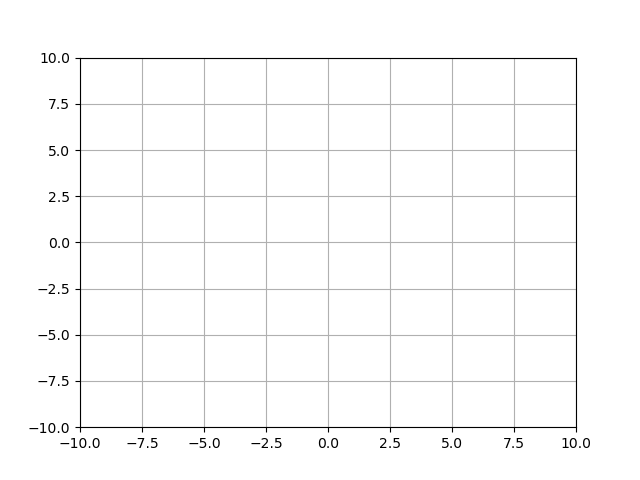

In [9]:
# Initialize the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(-10, 10)  # Set the x-axis limits (adjust as needed)
ax.set_ylim(-10, 10)  # Set the y-axis limits (adjust as needed)
ax.grid(True)

# Initialize scatter plots for lions and zebras
def update(frame):
    # Clear the previous scatter points
    ax.clear()
    # Update positions 
    
    for zebra in zebras:
        plt.scatter(zebra.x, zebra.y, color = 'black', label = 'zebras')
    
    for lion in lions:
        plt.scatter(lion.x, lion.y, color = 'red', label = 'lions')

    plt.grid()
    

    # Update vision, goals, and movement
    for zebra in zebras:
        zebra.vision(zebras, lions)
        if zebra.goal == 0:
            zebra.choose_goal()

    for lion in lions:
        lion.vision(lions, zebras)
        if lion.goal == 0:
            lion.choose_goal()

    for zebra in zebras:
        zebra.choose_direction()
        zebra.move()

    for lion in lions:
        lion.choose_direction()
        lion.move()

    for lion in lions:
        lion.track_collision(lions, zebras)  # Check if any zebras are about to be eaten

    for zebra in zebras:
        zebra.track_collision(zebras, lions)

# Create the animation
ani = FuncAnimation(fig, update, frames=60, interval=300, blit=True, repeat=False)
plt.show()
#Save the animation / uncomment next line and comment previous line
#ani.save('first_sim.mp4', writer = 'ffmpeg', fps = 3)
